In [397]:
import numpy as np
import matplotlib.pyplot as plt
import torch
#from base_model import EEGNet, Encoder, Decoder
# from utils import count_parameters
from numpy.fft import rfft, rfftfreq
from scipy.stats import wasserstein_distance
# from temp_model_old_17k import EEGNetOld_17k
import warnings

torch.set_default_dtype(torch.float32)
warnings.filterwarnings("ignore", category=FutureWarning)

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

cuda


In [398]:
%config InlineBackend.figure_format = 'retina'

In [399]:
def mse(pred, target):
    return np.mean((pred - target) ** 2)

def rrmse(pred, target):
    return np.sqrt(np.mean((pred - target) ** 2)) / np.sqrt(np.mean(target**2))

def srrmse(pred, target):
    pred_psd = np.abs(rfft(pred))**2
    target_psd = np.abs(rfft(target))**2
    return np.sqrt(np.mean((pred_psd - target_psd) ** 2)) / np.sqrt(np.mean(target_psd**2))

def relative(pred, target):
    return np.mean(np.abs(pred - target) / np.abs(target))

def sdr(pred, target):
    return np.mean(10*np.log10(np.sum(target**2, axis=-1)/np.sum((pred - target)**2, axis=-1)))

def corr(pred, target):
    n = len(pred)
    corrs = np.zeros(n)
    for i in range(n):
        corrs[i] = np.corrcoef(pred[i, :], target[i, :])[0, 1]
    return np.mean(corrs)

def psdErr(pred, target):
    n = len(pred)
    psdErrs = np.zeros(n)
    for i in range(n):
        psd_pred = np.abs(rfft(pred[i, :]))**2
        psd = np.abs(rfft(target[i, :]))**2
        prob_pp = psd_pred / np.sum(psd_pred)
        prob_p = psd / np.sum(psd)
        kld = np.sum(prob_pp * np.log(prob_pp / prob_p))
        psdErrs[i] = kld
    return np.mean(psdErrs)

def wasserstein(pred, target):
    n = len(pred)
    wass = np.zeros(n)
    for i in range(n):
        wass[i] = wasserstein_distance(pred[i, :], target[i, :])
    return np.mean(wass)

In [473]:
from sklearn.model_selection import train_test_split

modelpath = 'denoiseEEGMIXED_model_CBAMDROP_lowlronecycle_weighted_nonstd_bnorm_epoch_99.pt'
dtype=torch.float32
datatype = 'denoisenetmixed'
std=False

if datatype == 'denoisenet':
    raw_train_x = np.load("/DATA/arvasudata/datasets/denoisenet/data_15_500/test_input_15_500.npy").squeeze()
    raw_train_y = np.load("/DATA/arvasudata/datasets/denoisenet/data_15_500/test_output_15_500.npy").squeeze()
    N = raw_train_x.shape[0]

    trainx, testx, trainy, testy = train_test_split(raw_train_x, raw_train_y, test_size=.99, random_state=42)

elif datatype == 'denoisenetmixed':
    raw_train_x = np.load("/DATA/arvasudata/datasets/denoisenet/test_input.npy").squeeze()
    raw_train_y = np.load("/DATA/arvasudata/datasets/denoisenet/test_output.npy").squeeze()
    N = raw_train_x.shape[0]

    trainx, testx, trainy, testy = train_test_split(raw_train_x, raw_train_y, test_size=.99, random_state=42)

elif datatype == 'denoisenetEOG':
    raw_train_x = np.load('/DATA/arvasudata/datasets/denoisenet/EOG_EEG_test_input.npy')
    raw_train_y = np.load('/DATA/arvasudata/datasets/denoisenet/EOG_EEG_test_output.npy')
    N = raw_train_x.shape[0]
    trainx, testx, trainy, testy = train_test_split(raw_train_x, raw_train_y, test_size=.99, random_state=42)

elif datatype == 'denoisenetEOG55':
    raw_train_x = np.load('/DATA/arvasudata/datasets/denoisenet/EOG_EEG_test_input_55.npy')
    raw_train_y = np.load('/DATA/arvasudata/datasets/denoisenet/EOG_EEG_test_output_55.npy')
    N = raw_train_x.shape[0]
    trainx, testx, trainy, testy = train_test_split(raw_train_x, raw_train_y, test_size=.99, random_state=42)

elif datatype == 'denoisenetEMG':
    raw_train_x = np.load('/DATA/arvasudata/datasets/denoisenet/EMG_EEG_test_input.npy')
    raw_train_y = np.load('/DATA/arvasudata/datasets/denoisenet/EMG_EEG_test_output.npy')
    N = raw_train_x.shape[0]
    trainx, testx, trainy, testy = train_test_split(raw_train_x, raw_train_y, test_size=.99, random_state=42)

elif datatype == 'denoisenetEMG55':
    raw_train_x = np.load('/DATA/arvasudata/datasets/denoisenet/EMG_EEG_test_input_55.npy')
    raw_train_y = np.load('/DATA/arvasudata/datasets/denoisenet/EMG_EEG_test_output_55.npy')
    N = raw_train_x.shape[0]
    trainx, testx, trainy, testy = train_test_split(raw_train_x, raw_train_y, test_size=.99, random_state=42)

elif datatype == 'minisim':
    raw_train_x = np.load("/DATA/arvasudata/datasets/simulated/minicont_snr_-3_3.npy").squeeze()
    raw_train_y = np.load("/DATA/arvasudata/datasets/simulated/minicleans_snr_-3_3.npy").squeeze()
    N = raw_train_x.shape[0]

    trainx, testx, trainy, testy = train_test_split(raw_train_x, raw_train_y, test_size=.15, random_state=42)

elif datatype == 'bci':
    raw_train_y = np.load('/DATA/arvasudata/datasets/BCI4/cleans_BCI_3snr_test.npy')
    raw_train_x = np.load('/DATA/arvasudata/datasets/BCI4/conts_BCI_3snr_test.npy')
    N = raw_train_x.shape[0]

    trainx, testx, trainy, testy = train_test_split(raw_train_x, raw_train_y, test_size=.99, random_state=42)

elif datatype == 'sim':
    raw_train_x = np.load('/DATA/arvasudata/datasets/simulated/conts_snr_-3_3.npy') 
    raw_train_y = np.load('/DATA/arvasudata/datasets/simulated/cleans_snr_-3_3.npy')
    N = raw_train_x.shape[0]
    trainx, testx, trainy, testy = train_test_split(raw_train_x, raw_train_y, test_size=.05, random_state=42)


In [484]:
raw_train_x = np.load('/DATA/arvasudata/datasets/simulated/conts_snr_-3_3.npy') 
raw_train_y = np.load('/DATA/arvasudata/datasets/simulated/cleans_snr_-3_3.npy')
N = raw_train_x.shape[0]
trainx, testx, trainy, testy = train_test_split(raw_train_x, raw_train_y, test_size=.05, random_state=42)

np.save('/DATA/arvasudata/datasets/simulated/conts_snr_-3_3_test.npy', testx)
np.save('/DATA/arvasudata/datasets/simulated/cleans_snr_-3_3_test.npy', testy)
np.save('/DATA/arvasudata/datasets/simulated/conts_snr_-3_3_train.npy', trainx)
np.save('/DATA/arvasudata/datasets/simulated/cleans_snr_-3_3_train.npy', trainy)
N

1194543

In [474]:

# raw_train_x = np.load("/DATA/arvasudata/datasets/denoisenet/data_15_500/test_input_15_500.npy").squeeze()
# raw_train_y = np.load("/DATA/arvasudata/datasets/denoisenet/data_15_500/test_output_15_500.npy").squeeze()

trainx = torch.tensor(trainx.reshape(-1, 1, 512), dtype=dtype)
testx = torch.tensor(testx.reshape(-1, 1, 512), dtype=dtype).to(device)
trainy = torch.tensor(trainy.reshape(-1, 1, 512), dtype=dtype)
testy = torch.tensor(testy.reshape(-1, 1, 512), dtype=dtype)

arty = testx.cpu() - testy

def standardize(x):
    # z-score
    s = x.std(dim=2, keepdim=True)

    s[s == 0] = 1

    return (x - x.mean(dim=2, keepdim=True)) / s

def mean_center(x):
        return x - x.mean(dim=2, keepdim=True)

if std:
    print('standardised')
    #trainx = standardize(trainx)
    testx = standardize(testx)
    #trainy = standardize(trainy)
    testy = standardize(testy)
testy = testy.numpy()
arty = arty.numpy()

print(testx.shape, testy.shape, arty.shape)

# idx = 3400

# plt.figure()
# plt.plot(testx[idx, 0, :].cpu().numpy().squeeze(), label='Input')
# plt.plot(testy[idx, 0, :], label='Target')
# plt.legend()
# plt.show()

# plt.figure()
# plt.plot(testx[idx, 0, :].cpu().numpy().squeeze()-testy[idx, 0, :].squeeze(), label='Noise', color='green')
# plt.legend()
# plt.show()

torch.Size([7920, 1, 512]) (7920, 1, 512) (7920, 1, 512)


In [ ]:
def evalAllMetrics(model, testx, testy, typ='eeg'):
    model.eval()

    if typ == 'eeg':
        idx = 0
    elif typ == 'art':
        idx = 1

    with torch.no_grad():
        pred = model(testx)
        # pred_art = pred[idx].cpu().numpy().squeeze()
        # pred = testx.cpu().numpy().squeeze() - pred_art
        pred = pred[idx].cpu().numpy().squeeze()
        print(f'{pred.shape}, {testy.shape}')
        mse_val = mse(pred, testy)
        rel_val = relative(pred, testy)
        sdr_val = sdr(pred, testy)
        corr_val = corr(pred, testy)
        psd_val = psdErr(pred, testy)
        wass_val = wasserstein(pred, testy)
        rrmse_val = rrmse(pred, testy)
        srrmse_val = srrmse(pred, testy)
    print(f'MSE:                {mse_val:.4f}')
    print(f'RMSE:               {np.sqrt(mse_val):.4f}')
    print(f'RRMSE:              {rrmse_val:.4f}')
    print(f'SRRMSE:             {srrmse_val:.4f}')
    print(f'SDR:                {sdr_val:.4f} dB')
    print(f'Correlation:        {corr_val:.4f}')
    print(f'PSD KLD:            {psd_val:.4f}')
    print(f'PSD Wasserstein:    {wass_val:.4f}')

In [476]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import rfft, rfftfreq
import torch
from torch.nn import Module
from torch import nn
import ptwt
from tslearn.metrics import SoftDTWLossPyTorch

class Decoder(Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.post_latent3 = nn.Sequential(
            # in - 128x8, out - 128x16
            nn.ConvTranspose1d(128, 128, kernel_size=4, stride=2, padding=1, groups=16),
            nn.LeakyReLU()
        )

        self.post_latent2 = nn.Sequential(
            # in - 256x16 (after cat), out - 64x32
            nn.Conv1d(256, 128, kernel_size=3, stride=1, padding=1, padding_mode='reflect', groups=64),
            nn.LeakyReLU(),
            nn.ConvTranspose1d(128, 64, kernel_size=6, stride=2, padding=2, groups=32),
            nn.LeakyReLU()
        )

        self.post_latent1 = nn.Sequential(
            # in - 128x32 (after cat), out - 32x64
            nn.Conv1d(128, 64, kernel_size=5, stride=1, padding=2, padding_mode='reflect', groups=32),
            nn.LeakyReLU(),
            nn.ConvTranspose1d(64, 32, kernel_size=6, stride=2, padding=2, groups=16),
            nn.LeakyReLU()
        )

        self.HP_inverse = nn.Sequential(
            # in - 32x64 (after cat), out - 1x257
            nn.Conv1d(32, 16, kernel_size=5, stride=1, padding=2, padding_mode='reflect', groups=8),  # 16x64
            nn.LeakyReLU(),
            nn.ConvTranspose1d(16, 8, kernel_size=4, stride=2, padding=4, dilation=3, groups=4),  # 8x128
            nn.LeakyReLU(),
            nn.ConvTranspose1d(8, 4, kernel_size=3, stride=2, padding=3, dilation=4),    # 4x257
            nn.LeakyReLU(),
            nn.Conv1d(4, 1, kernel_size=3, stride=1, padding=1, padding_mode='reflect'), # 1x257
            nn.Tanh()
        )

        self.LP_inverse = nn.Sequential(
            # in - 32x64 (after cat), out - 1x257
            nn.Conv1d(32, 16, kernel_size=5, stride=1, padding=2, padding_mode='reflect', groups=8),  # 16x64
            nn.LeakyReLU(),
            nn.ConvTranspose1d(16, 8, kernel_size=10, stride=2, padding=4, groups=4),
            nn.LeakyReLU(),
            nn.ConvTranspose1d(8, 4, kernel_size=9, stride=2, padding=3, groups=2),
            nn.LeakyReLU(),
            nn.ConvTranspose1d(4, 1, kernel_size=3, stride=1, padding=1),   # 1x257
            nn.Tanh()
        )

        self.lp_compress = nn.Conv1d(2, 1, kernel_size=7, stride=1, padding=3, padding_mode='reflect')
        self.hp_compress = nn.Conv1d(2, 1, kernel_size=3, stride=1, padding=1, padding_mode='reflect')

        self.dwt_conv_inverse = nn.Sequential(
            # in - 2x257, out - 1x512 (hopefully)
            nn.ConvTranspose1d(2, 16, kernel_size=12, stride=2, padding=6),
            nn.LeakyReLU(),
            nn.Conv1d(16, 1, kernel_size=3, stride=1, padding=1, padding_mode='reflect')
        )


    def forward(self, x, skip_states):
        # pre-latent
        x = self.post_latent3(x)
        # print(f'post_latent3: {x.shape}')

        x = torch.cat((x, skip_states[-1]), dim=1)
        x = self.post_latent2(x)
        # print(f'post_latent2: {x.shape}')

        x = torch.cat((x, skip_states[-2]), dim=1)
        x = self.post_latent1(x)
        # print(f'post_latent1: {x.shape}')

        # split 32x64 into lp and hp
        # should use torch.split()? is that faster?
        lpi, hpi = torch.split(x, 16, dim=1)
        lp, hp = skip_states[-3]

        lp = torch.cat((lp, lpi), dim=1)
        hp = torch.cat((hp, hpi), dim=1)

        lp = self.LP_inverse(lp)
        hp = self.HP_inverse(hp)
        # print(f'lp: {lp.shape}, hp: {hp.shape}')

        lp_orig, hp_orig = torch.split(skip_states[-4], 1, dim=1)
        lp = torch.concat((lp, lp_orig), dim=1)
        hp = torch.concat((hp, hp_orig), dim=1)

        lp = self.lp_compress(lp)
        hp = self.hp_compress(hp)
        # print(f'lp_compress: {lp.shape}, hp_compress: {hp.shape}')

        x = torch.concat((lp, hp), dim=1)

        x = self.dwt_conv_inverse(x)
        # print(f'dwt_conv_inverse: {x.shape}')

        return x

class Encoder(Module):
    def __init__(self, wavelet='db2'):
        super(Encoder, self).__init__()

        self.wavelet = wavelet

        self.skip_states = []

        self.dwt_conv = nn.Sequential(
            # low freq so large kernel and stride
            # in - 1x512, out - 2x257
            nn.Conv1d(1, 16, kernel_size=3, stride=1, padding=1, padding_mode='reflect'),
            nn.Conv1d(16, 2, kernel_size=12, stride=2, padding=6, padding_mode='reflect')
        )
        self.LP_conv_dws = nn.Sequential(
            # low freq conv pipeline - depth-wise separable
            # in - 2x257, out - 16x64

            # first bring up channels
            nn.Conv1d(1, 4, kernel_size=3, stride=1, padding=1, padding_mode='reflect'),

            # adding groups arg makes it depth-wise separable
            nn.Conv1d(4, 8, kernel_size=9, stride=2, padding=3, padding_mode='reflect', groups=2),
            nn.Conv1d(8, 16, kernel_size=10, stride=2, padding=4, padding_mode='reflect', groups=4)

            # should be N x 16 x 64 at this point
        )

        # why are we using dilation for high frequency?
        self.HP_conv = nn.Sequential(
            nn.Conv1d(1, 4, kernel_size=3, stride=1, padding=1, padding_mode='reflect'),

            # dilation 4
            nn.Conv1d(4, 8, kernel_size=3, stride=2, padding=3, dilation=4, padding_mode='reflect'),
            nn.Conv1d(8, 16, kernel_size=4, stride=2, padding=4, dilation=3, padding_mode='reflect')

            # N x 16 x 64
        )

        # change pre-latent to increase depth while decreasing length
        # change LP and HP final depths
        # can later increase to 2 convs per depth level

        self.pre_latent1 = nn.Sequential(
            # do some conv and then bring to two channels
            # can do dws to reduce params
            # in - 32x64, out - 64x32
            nn.Conv1d(32, 64, kernel_size=5, stride=2, padding=2, padding_mode='reflect', groups=8),
            nn.LeakyReLU(),
        )
        self.pre_latent2 = nn.Sequential(
            # in - 64x32, out - 128x16
            nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=2, padding_mode='reflect', groups=16),
            nn.LeakyReLU(),
        )
        self.pre_latent3 = nn.Sequential(
            # in - 128x16, out - 256x8
            nn.Conv1d(128, 256, kernel_size=3, stride=2, padding=1, padding_mode='reflect', groups=32),
            nn.LeakyReLU(),
        )

    def standardize(self, x):
        # z-score
        return (x - x.mean())/x.std()


    def forward(self, x):
        self.skip_states = []
        x = self.dwt_conv(x)
        x = self.standardize(x)
        dwtx = x.clone()
        # print(f'dwt shape: {x.shape}')
        self.skip_states.append(dwtx)

        # lp/hp conv
        lp, hp = torch.split(x, 1, dim=1)

        lp = self.LP_conv_dws(lp)
        hp = self.HP_conv(hp)
        # print(f'lp shape: {lp.shape}, hp shape: {hp.shape}')
        self.skip_states.append((lp.clone(), hp.clone()))

        # concat
        x = torch.cat((lp, hp), dim=1)

        # pre-latent
        x = self.pre_latent1(x)
        # print(f'pre-latent1 shape: {x.shape}')
        self.skip_states.append(x.clone())
        x = self.pre_latent2(x)
        # print(f'pre-latent2 shape: {x.shape}')
        self.skip_states.append(x.clone())
        x = self.pre_latent3(x)
        # print(f'pre-latent3 shape: {x.shape}')

        eeg, artefact = torch.split(x, 128, dim=1)
        # print(f'eeg shape: {eeg.shape}, artefact shape: {artefact.shape}')
        return eeg, artefact, dwtx

class EEGNet(Module):
    def __init__(self, wavelet='db2', dws=True, gamma=0.1, waveletWeight=0.1):
        super(EEGNet, self).__init__()
        self.encoder = Encoder(wavelet=wavelet)
        self.eeg_decoder = Decoder()
        self.art_decoder = Decoder()

        self.gamma = gamma
        self.w = waveletWeight
        self.dtwLoss = SoftDTWLossPyTorch(gamma=self.gamma)

    def standardize(self, x):
        # z-score
        return (x - x.mean())/x.std()

    def forward(self, x):
        # verify that skip states are being passed correctly.
        x_inp = x.clone()
        eeg_z, artefact_z, dwtx = self.encoder(x)
        # print(len(self.encoder.skip_states))
        eeg = self.eeg_decoder(eeg_z, self.encoder.skip_states)
        artefact = self.art_decoder(artefact_z, self.encoder.skip_states)

        return eeg, artefact, eeg_z, artefact_z, dwtx, x_inp

    def reconstructionLoss(self, x, y):
        return self.dtwLoss(x, y).mean()

    def mutualInfoLoss(self):
        # multiply by a small scaling factor, because MI loss will encourage x = constant
        return 0

    def waveletLoss(self, x, cA, cD):
        assert x.shape[1] == 2, f"dwt_conv should output 2 channels (LP and HP). current shape: {x.shape}"
        loss = nn.L1Loss()
        return loss(x[:, 0, :].squeeze(), cA.squeeze()) + loss(x[:, 1, :].squeeze(), cD.squeeze())

    def loss(self, f, eeg_y, artefact_y):
        # time this, tuple unpacking can be slow
        eeg, artefact, eeg_z, artefact_z, dwtx, x_inp = f
        cA, cD = self.dwt(x_inp, wavelet=self.encoder.wavelet)
        eegrec = self.reconstructionLoss(eeg, eeg_y)
        artefactrec = self.reconstructionLoss(artefact, artefact_y)
        mim = self.mutualInfoLoss()
        wvl = self.waveletLoss(dwtx, cA, cD)
        # print(f'mag test. eegrec: {eegrec}, artefactrec: {artefactrec}, mim: {mim}, wvl: {wvl}')
        return eegrec + artefactrec + mim + self.w*wvl

    def dwt(self, x, wavelet='db2'):
        # cA is low, cD is high
        # question - which signal extension mode to use?
        # question/idead - since LP is very close to original signal (maybe because we're using EOG)
        # we can try pyramid DWT and use second order LP and HP, or even all 3.
        # could define custom wavelet according to frequency bands preference

        cA, cD = ptwt.wavedec(x, wavelet, level=1)
        # print(f'inside dwt, x - {x.shape}, cA - {cA.shape}, cD - {cD.shape}')
        return cA, cD

In [477]:
testx.shape, testy.shape

(torch.Size([7920, 1, 512]), (7920, 1, 512))

In [478]:
model = torch.load(f'{modelpath}', weights_only=False, map_location='cpu')
model.to('cpu')
model.eval()
art = testx.cpu()-testy
art = art[:, 0, :].numpy()
print(testx.shape, testy.shape, art.shape)
# model.to(device)
with torch.no_grad():
    evalAllMetrics(model, testx.to('cpu'), testy[:, 0, :], typ='eeg')

torch.Size([7920, 1, 512]) (7920, 1, 512) (7920, 512)


/tmp/ipykernel_3763144/2602077927.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  art = testx.cpu()-testy


(7920, 512), (7920, 512)
MSE:                0.0532
RMSE:               0.2306
RRMSE:              0.4168
SRRMSE:             0.4043
SDR:                7.0432 dB
Correlation:        0.8728
PSD KLD:            0.2301
PSD Wasserstein:    0.0621


In [479]:
from utils import count_parameters
count_parameters(model)

Total Trainable Params: 60383


60383

In [480]:
idx = 0

0
sample shape: (512,), target shape: (512,)


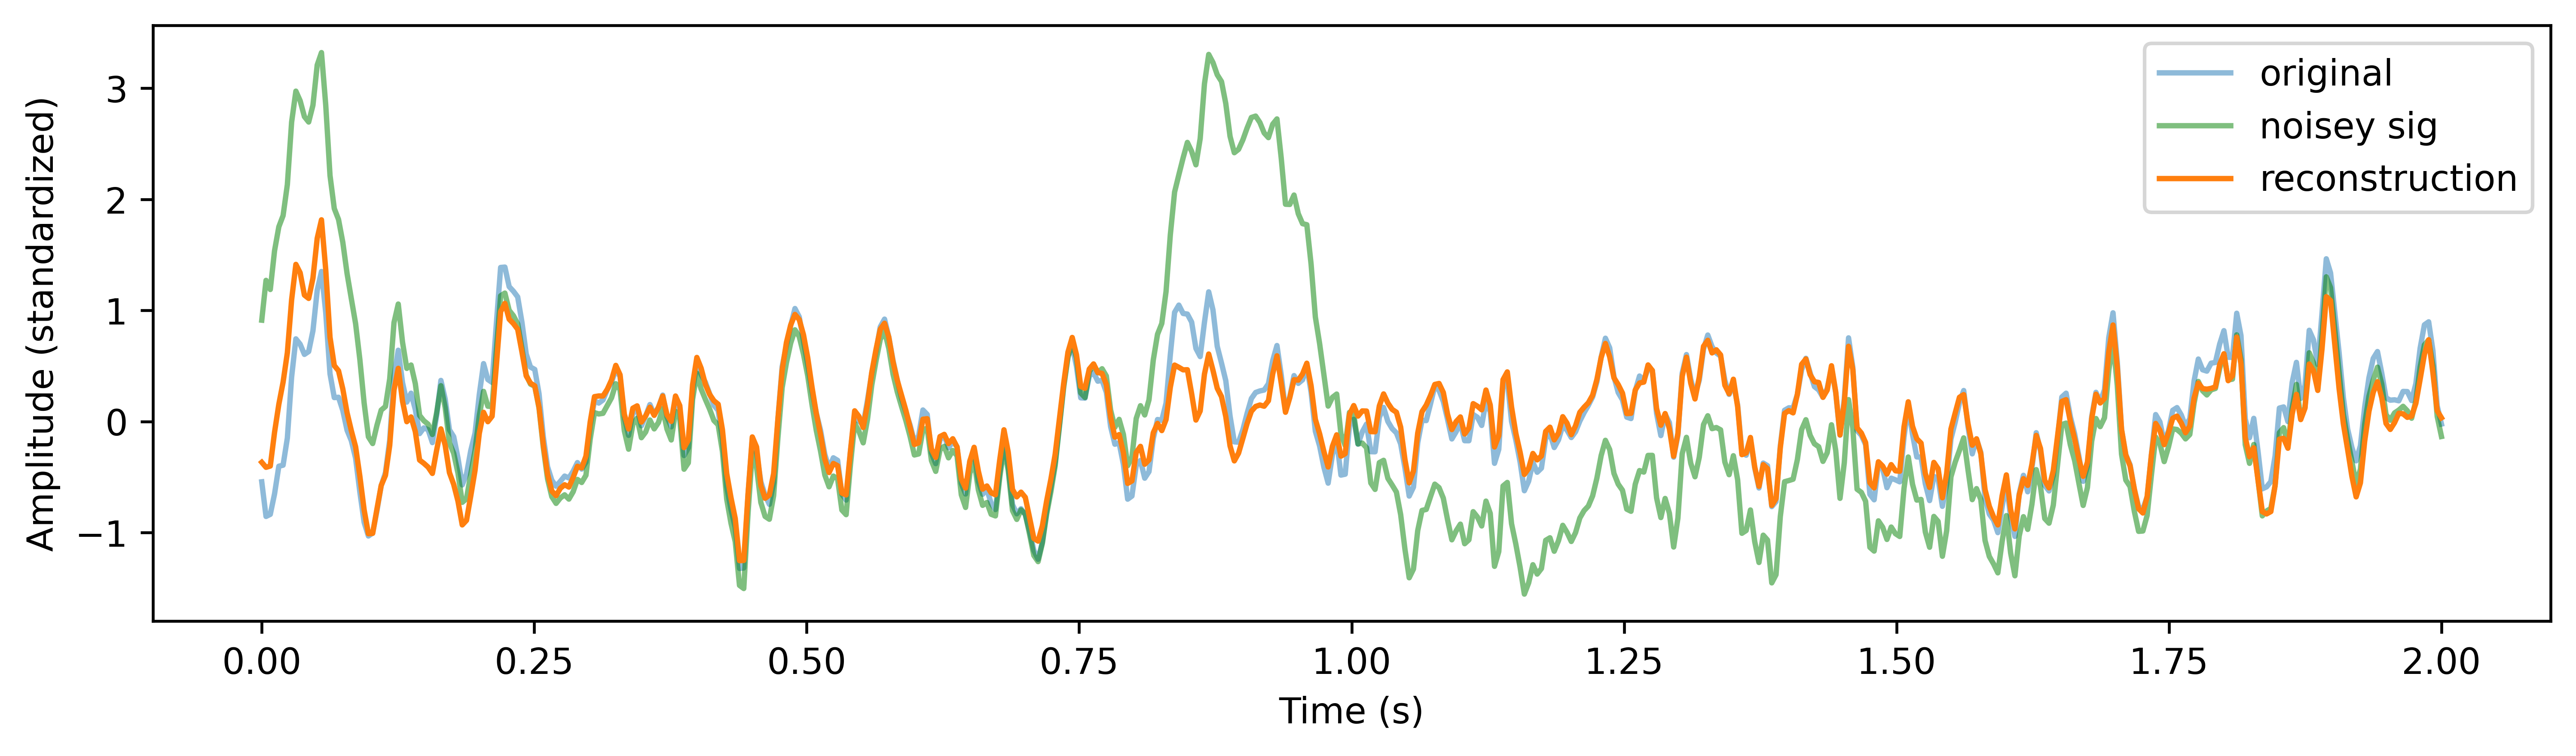

In [481]:
t = np.linspace(0, 2, 512)

# idx = np.random.randint(0, testx.shape[0])
print(idx)

pred = model(testx[idx].reshape(1, 1, 512).cpu())
sample = pred[0].cpu().detach().numpy().squeeze()
#sample = testx[idx].cpu().numpy().squeeze() - sample_art
target = testy[idx].flatten()
noise = testx[idx].cpu().numpy().flatten() - target
print(f'sample shape: {sample.shape}, target shape: {target.shape}')
plt.figure(figsize=(12, 3), dpi=300)
plt.plot(t, target, label='original', alpha=0.5)
plt.plot(t, noise+target, label='noisey sig', color='green', alpha=0.5)
plt.plot(t, sample, label='reconstruction')
plt.legend()
plt.ylabel('Amplitude (standardized)')
plt.xlabel('Time (s)')
plt.show()

idx += 1

# sample_latent = pred[2].cpu().detach().numpy().squeeze().T
# print(f'sample_latent shape: {sample_latent.shape}')
# plt.figure(dpi=300)
# fig, axs = plt.subplots(9, 1, sharex=False)
# axs[0].plot(target)
# for i in range(8):
#     axs[i+1].plot(sample_latent[i, :])

In [482]:
import pywt, torch
T = 2
srate = 256
dt = 1 / srate
t = np.arange(0, T, 1/srate)

frex = np.linspace(1, 55, 96)
wavelet='cmor1.0-1.5'
fc = pywt.central_frequency(wavelet)
scales = fc / (frex * dt)

torch.Size([96, 512])
torch.Size([1, 96, 512])
sample shape: (12, 512), target shape: torch.Size([12, 512])


/tmp/ipykernel_3763144/779425923.py:48: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


<Figure size 3600x900 with 0 Axes>

<Figure size 3000x1500 with 0 Axes>

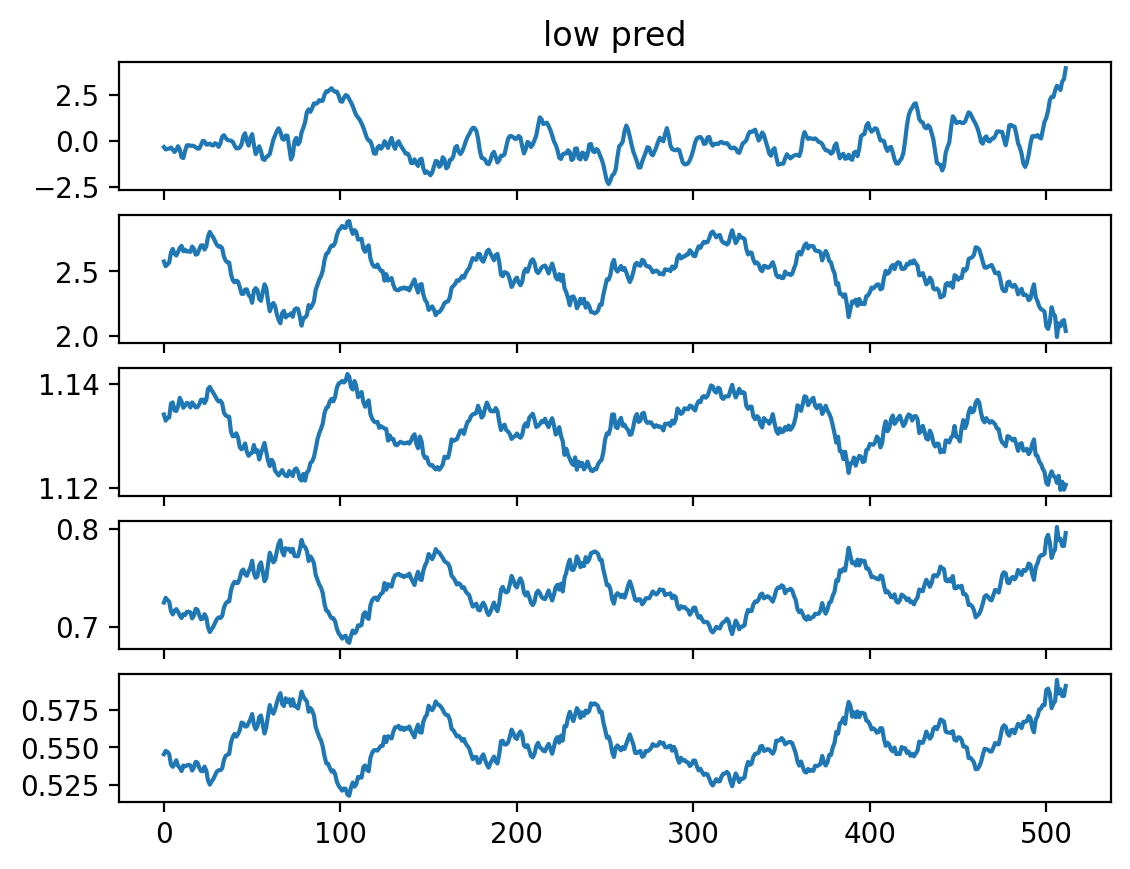

<Figure size 3000x1500 with 0 Axes>

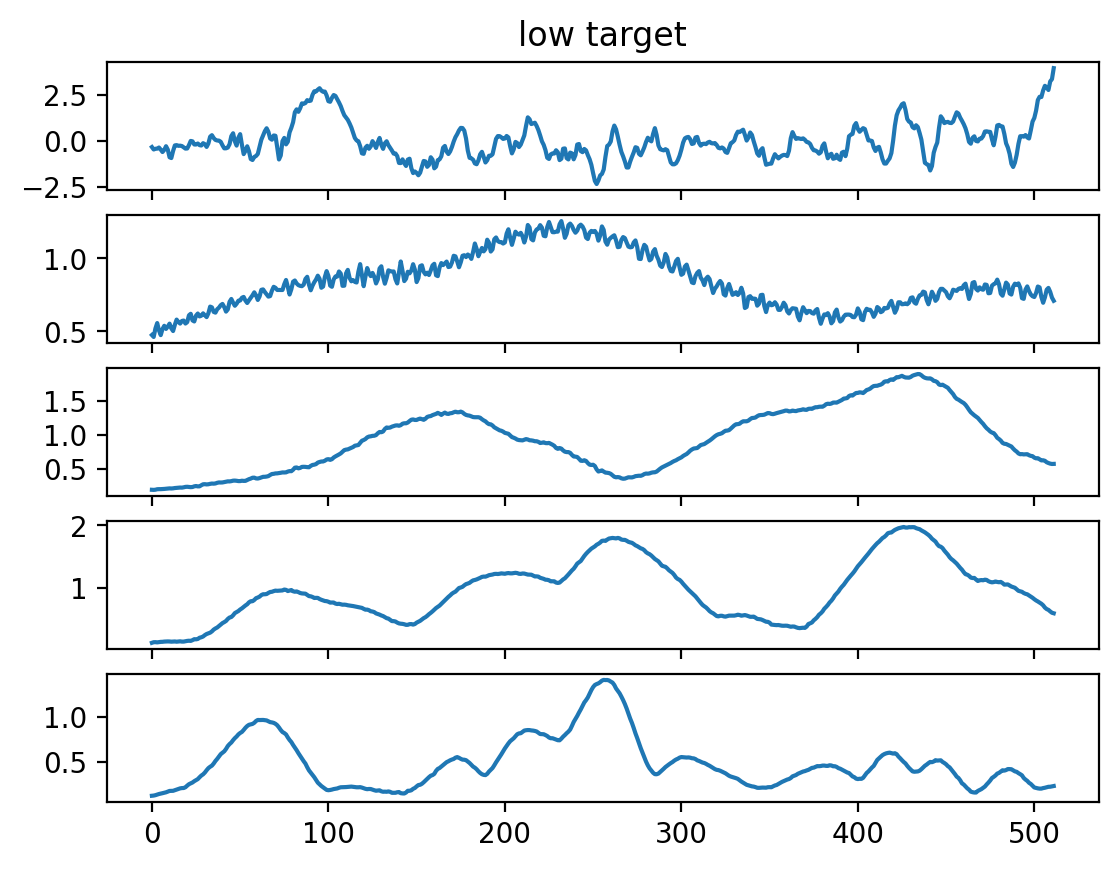

<Figure size 3000x1500 with 0 Axes>

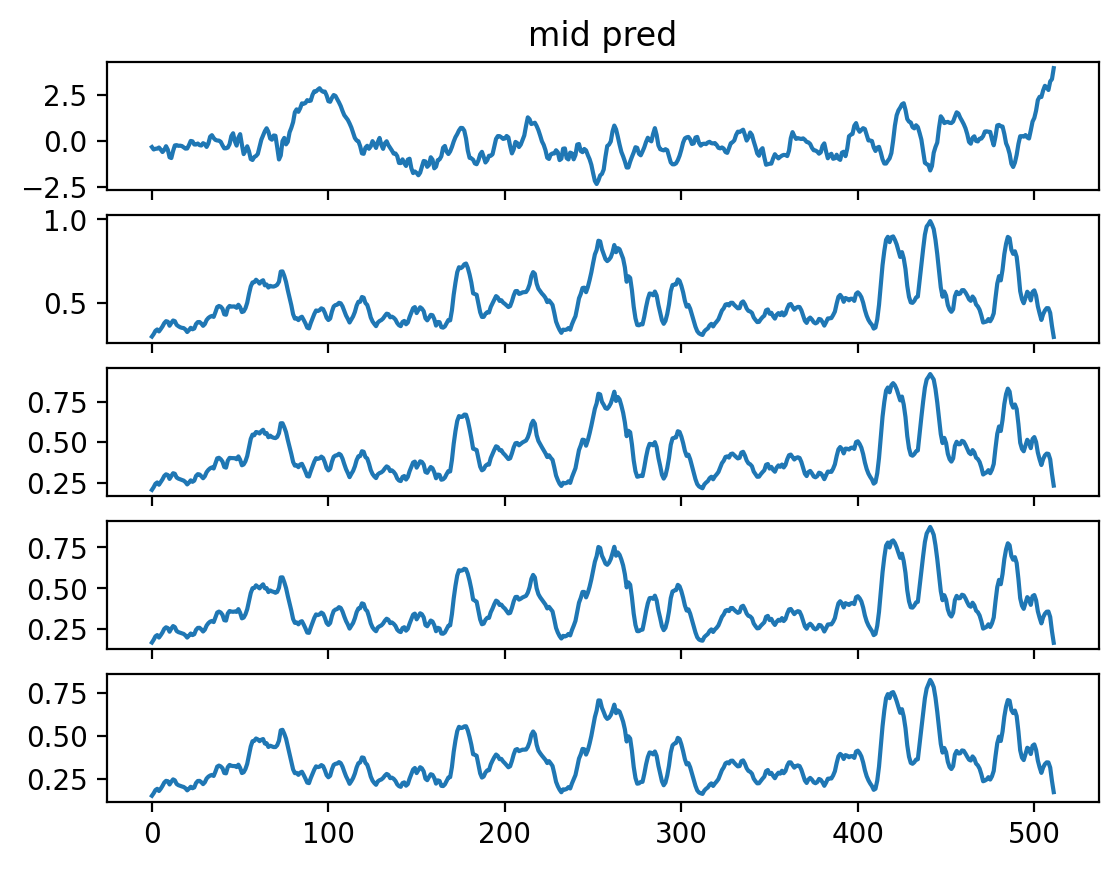

<Figure size 3000x1500 with 0 Axes>

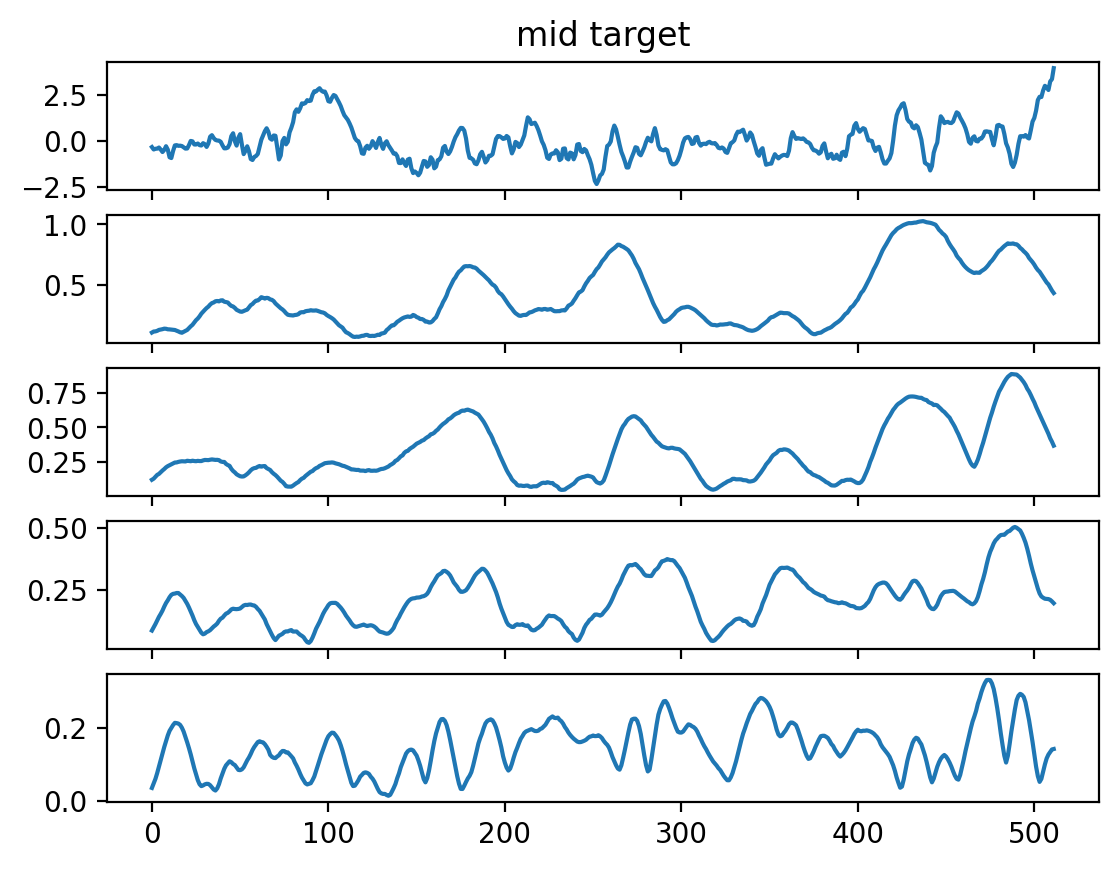

<Figure size 3000x1500 with 0 Axes>

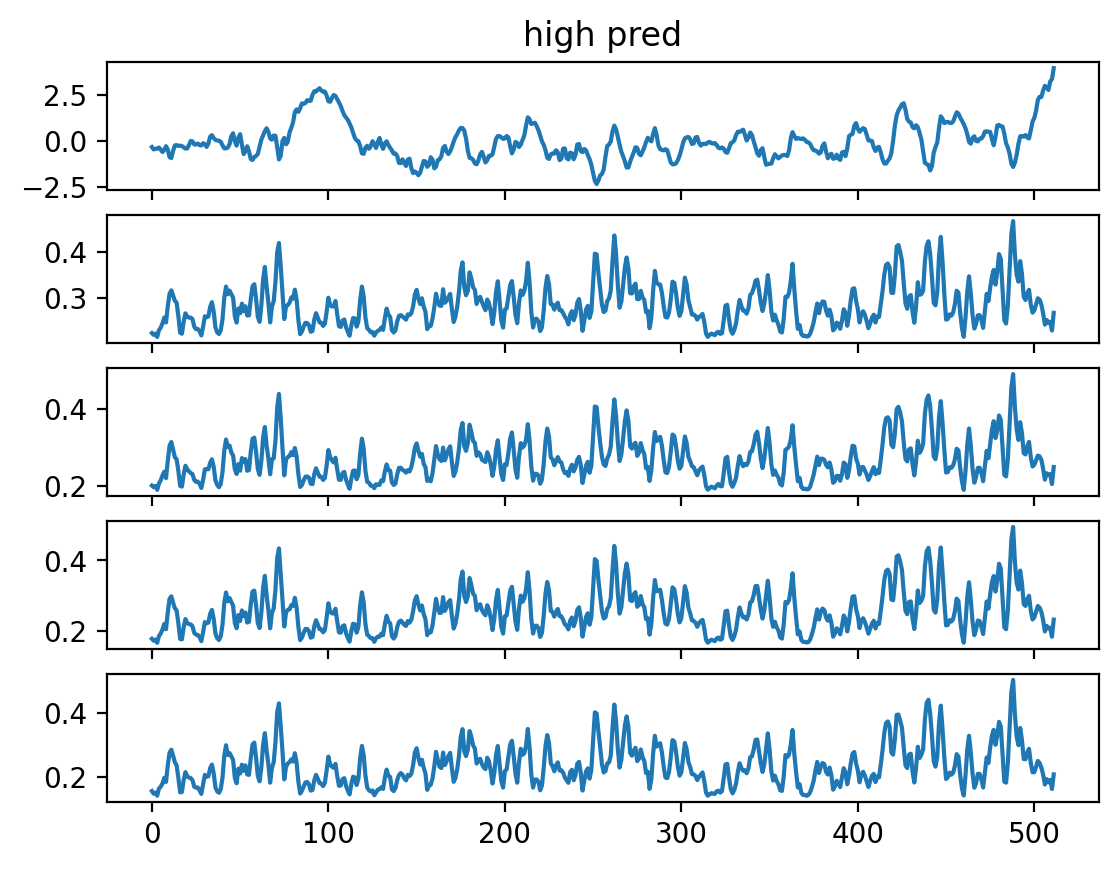

<Figure size 3000x1500 with 0 Axes>

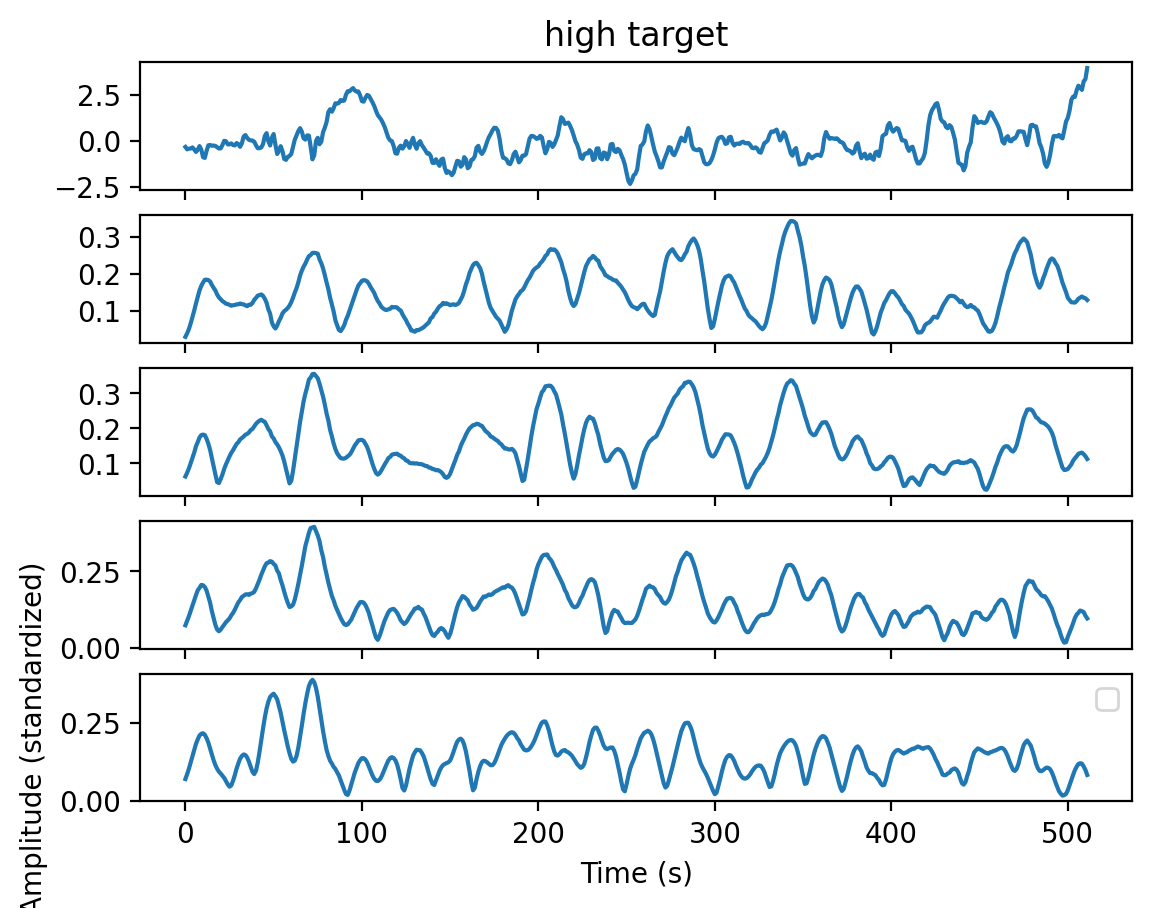

In [483]:

def getwavtensor(x):
    coeffs, _ = pywt.cwt(x, scales, wavelet, sampling_period=dt)
    coeffs = torch.tensor(np.abs(coeffs).squeeze().transpose(0, 1))

    n_freqs = coeffs.shape[0]
    print(coeffs.shape)

    coeffs = coeffs.reshape(1, -1, 512)
    print(coeffs.shape)
    lowcoeffs, midcoeffs, highcoeffs = torch.split(coeffs, n_freqs//3, dim=1)

    tempcoeffs = []
    for part in [lowcoeffs, midcoeffs, highcoeffs]:
        B, F, T = part.shape
        part = part[:, :F - (F % 4), :]  # make divisible by 4
        part = part.reshape(B, 4, F // 4, T).mean(dim=2)
        tempcoeffs.append(part)

    wavelet_features = torch.cat(tempcoeffs, dim=1)
    return wavelet_features


pred = model(testx[idx].reshape(1, 1, 512).cpu())
sample = pred[4].cpu().detach().numpy().squeeze()
#sample = testx[idx].cpu().numpy().squeeze() - sample_art
target = getwavtensor(testy[idx]).squeeze()
print(f'sample shape: {sample.shape}, target shape: {target.shape}')
plt.figure(figsize=(12, 3), dpi=300)

def plot_wavelet(x, origsig, title):
    f = x.squeeze()
    plt.figure(figsize=(10, 5), dpi=300)
    fig, axs = plt.subplots(5, 1, sharex=True)
    axs[0].plot(origsig.squeeze())
    axs[1].plot(f[0, :])
    axs[2].plot(f[1, :])
    axs[3].plot(f[2, :])
    axs[4].plot(f[3, :])
    axs[0].set_title(title)

plot_wavelet(sample[:4, :], testx[idx].cpu(), 'low pred')
plot_wavelet(target[:4, :], testx[idx].cpu(), 'low target')
plot_wavelet(sample[4:8, :], testx[idx].cpu(), 'mid pred')
plot_wavelet(target[4:8, :], testx[idx].cpu(), 'mid target')
plot_wavelet(sample[8:12, :], testx[idx].cpu(), 'high pred')
plot_wavelet(target[8:12, :], testx[idx].cpu(), 'high target')

plt.legend()
plt.ylabel('Amplitude (standardized)')
plt.xlabel('Time (s)')
plt.show()
idx += 1